# Douban Network Analysis

### 1. Dependencies

In [0]:
!pip install networkx==2.4
!pip install python-louvain

In [0]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from community import best_partition, modularity
import scipy.spatial.distance as spt
from collections import Counter
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### 2. Load Data

In [0]:
DATA_PATH = '/content/drive/My Drive/Network Reseearch/datasets/out.douban'

edges = []
with open(DATA_PATH,'r') as f:
    for line in f:
        line = line.strip().split()
        if len(line) ==2:
            edges.append([int(line[0]),int(line[1])])

G = nx.from_edgelist(edges)

### 3. Connected Components Analysis

In [0]:
components = list(nx.connected_components(G))
component_sizes = {i:len(comp) for i,comp in enumerate(components)}
print('Components count: {}'.format(len(components)))
for k,v in component_sizes.items():
    print("Component {} has size: {}".format(k,v))

Components count: 1
Component 0 has size: 154908


### 4. Graph Statistics

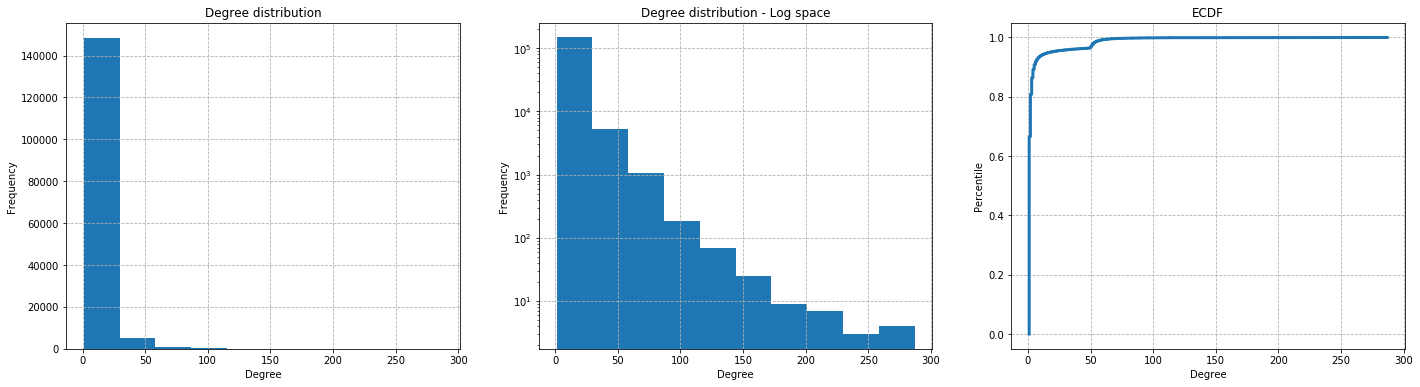

Mean Degree: 4.22, Assortativity: -0.18


In [0]:
def ecdf(array):
    return (np.sort(array),np.arange(1, len(array) + 1) / len(array))

figsize(24,6)
plt.subplot(1,3,1)

degrees = list(dict(nx.degree(G)).values())

plt.hist(degrees)
plt.title("Degree distribution")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True,linestyle = '--')

plt.subplot(1,3,2)
plt.hist(degrees,log = True)
plt.title("Degree distribution - Log space")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True,linestyle = '--')

plt.subplot(1,3,3)
x,y = ecdf(degrees)
plt.plot(x,y,linewidth = 3)
plt.grid(True,linestyle = '--')
plt.xlabel('Degree')
plt.ylabel('Percentile')
plt.title('ECDF')
plt.show()

assort = nx.degree_assortativity_coefficient(G)
degrees = list(dict(nx.degree(G)).values())
degree_stats = pd.DataFrame(zip([1,10,25,50,75,90,99,100],np.percentile(degrees,[1,10,25,50,75,90,99,100])),columns = ['Percentile','Value'])
mean_degree = np.mean(degrees)

print('Mean Degree: {}, Assortativity: {}'.format(round(mean_degree,2),round(assort,2)))

In [0]:
degree_stats

Percentile  Value
0           1    1.0
1          10    1.0
2          25    1.0
3          50    1.0
4          75    2.0
5          90    5.0
6          99   57.0
7         100  287.0

- This is heavily unbalanced graph with lots of nodes degree = 1, only small portion larger than 1.
- Slightly disassortative.

In [0]:
from tqdm import tqdm

In [0]:
def rich_club_coefficient(G,ks = []):
    '''
        Calculate rich club coefficient
        G: networkx graph
        ks: list of node degrees to define a rich club
    '''

    coefs = {}

    if len(ks) ==0:
        ks = set(dict(G.degree()).values())

    degrees = [(n,deg) for n,deg in dict(G.degree()).items()]

    for k in tqdm(ks):
        rich_nodes = [n for n,deg in degrees if deg >= k]

        if len(rich_nodes) <= 1:
            coefs[k] = 0
            continue
        else:
            n_rich_nodes = len(rich_nodes)
            n_rich_edges = len(G.subgraph(rich_nodes).edges())
            rcc = n_rich_edges / ((n_rich_nodes) * (n_rich_nodes - 1)/2 )
            coefs[k] = rcc

    figsize(8,6)
    plt.bar(list(coefs.keys()),list(coefs.values()))
    plt.title("Rich club coefficient")
    plt.xlabel('Node degree')
    plt.ylabel('Rich club coeficient')
    plt.show()
    return coefs

def draw_rich_club_coef(G):
    figsize(15,6)
    plt.subplot(1,2,1)
    nx.draw(G,with_labels = True)
    plt.subplot(1,2,2)
    rich_club_coefficient(G,range(1,12))
    plt.show()

100%|██████████| 178/178 [00:18<00:00,  9.58it/s]


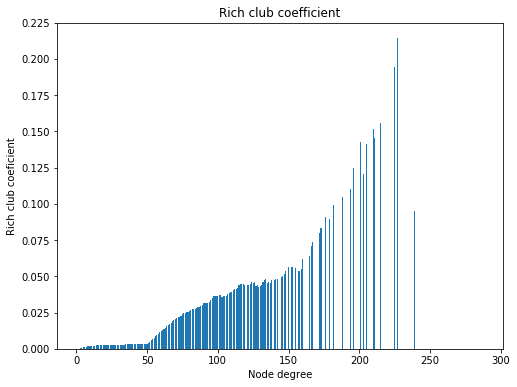

In [0]:
rccs = rich_club_coefficient(G)

**Networkx implementation**

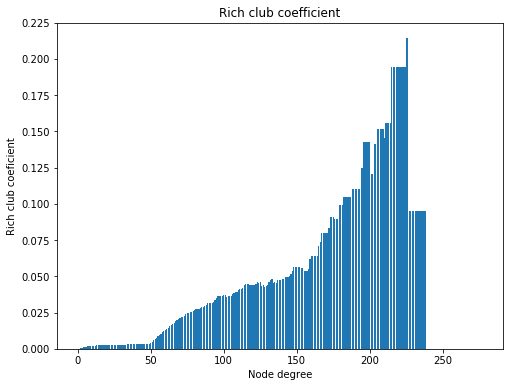

In [0]:
rcc1 = nx.rich_club_coefficient(G,normalized = False)
plt.bar(list(rcc1.keys()),list(rcc1.values()))
plt.title("Rich club coefficient")
plt.xlabel('Node degree')
plt.ylabel('Rich club coeficient')
plt.show()

- 1. Node degree distribution follows power law distribution: there are few nodes having high degrees.
- 2. The lower degree nodees having lower rich club coefficient: low degree nodes tend to connect to high degree nodes.
- 3. High degree nodes having higher rich club coefficient - high degree nodes interconnected, however, these connections is not obvious on rich club coefficient (fewer nodes)

### 5. Subgraph visualizations

In [0]:
def n_step_subgraph(G, node = 9,level = 3, return_sub_graph = False):

    '''
        Generate subgraph from one node, can be multiple step
        Parameters:
        --------
            G: networkx graph
            node: center node to start from
            level: steps away from center node
            return_sub_graph: boolean return graph of list of nodes

        Returns:
            list of nodes in subgraph
            or
            networkx subgraph(Graph)
    '''

    flatten = lambda coll :[ele for lis in coll for ele in lis ]
    neighbors = [node]
    for _ in range(level):
        neighbors += flatten([list(G.neighbors(nei)) for nei in neighbors])

    if return_sub_graph:
        return G.subgraph(neighbors)
    else:
        return neighbors

#### Node 12 subgraph

Number of nodes: 296


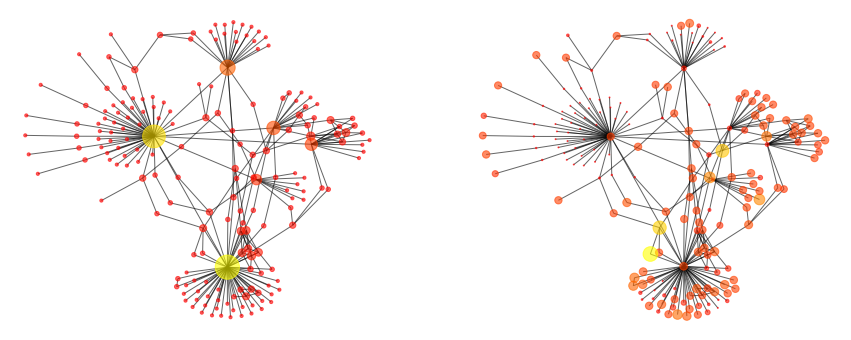

In [0]:
n = 12
step = 2
neis = n_step_subgraph(G,n,step)
print('Number of nodes: {}'.format(len(neis)))

figsize(15,6)
S = G.subgraph(neis)
pos = nx.spring_layout(S)
dc = list(dict(nx.degree_centrality(S)).values())
plt.subplot(1,2,1)
nx.draw(S,alpha = .6,node_color = dc,cmap = plt.get_cmap('autumn'),node_size = 10*np.array(list(dict(S.degree()).values())),pos =pos)

plt.subplot(1,2,2)
deg_lookup = {n:d for n,d in dict(nx.degree(G)).items() if n in neis}
s_deg = [deg_lookup[n] for n in S.nodes()]
nx.draw(S,alpha = .6,node_color = s_deg,cmap = plt.get_cmap('autumn'),node_size =  np.array(s_deg),pos = pos)
plt.show()

#### Node 11045 Subgraph

Number of nodes: 522


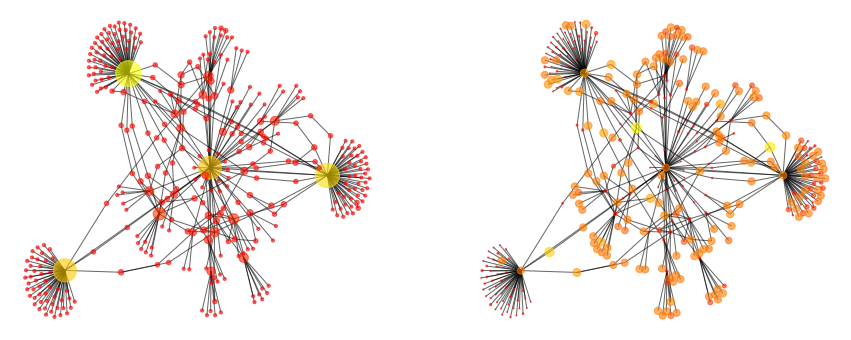

In [0]:
n = 11045
step = 3
neis = n_step_subgraph(G,n,step)
print('Number of nodes: {}'.format(len(neis)))

figsize(15,6)
S = G.subgraph(neis)
pos = nx.spring_layout(S)
dc = list(dict(nx.degree_centrality(S)).values())
plt.subplot(1,2,1)
nx.draw(S,alpha = .6,node_color = dc,cmap = plt.get_cmap('autumn'),node_size = 10*np.array(list(dict(S.degree()).values())),pos =pos)

plt.subplot(1,2,2)
deg_lookup = {n:d for n,d in dict(nx.degree(G)).items() if n in neis}
s_deg = [deg_lookup[n] for n in S.nodes()]
nx.draw(S,alpha = .6,node_color = s_deg,cmap = plt.get_cmap('autumn'),node_size =  np.array(s_deg),pos = pos)
plt.show()

#### Node 88765 subgraph

Number of nodes: 532


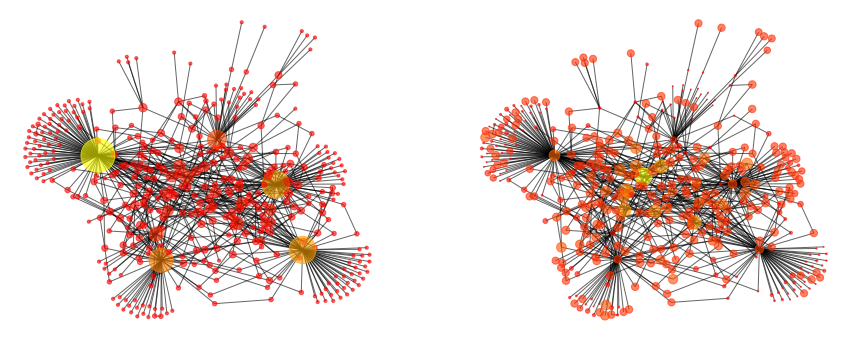

In [0]:
n = 88765
step = 3
neis = n_step_subgraph(G,n,step)
print('Number of nodes: {}'.format(len(neis)))

figsize(15,6)
S = G.subgraph(neis)
pos = nx.spring_layout(S)
dc = list(dict(nx.degree_centrality(S)).values())
plt.subplot(1,2,1)
nx.draw(S,alpha = .6,node_color = dc,cmap = plt.get_cmap('autumn'),node_size = 10*np.array(list(dict(S.degree()).values())),pos =pos)

plt.subplot(1,2,2)
deg_lookup = {n:d for n,d in dict(nx.degree(G)).items() if n in neis}
s_deg = [deg_lookup[n] for n in S.nodes()]
nx.draw(S,alpha = .6,node_color = s_deg,cmap = plt.get_cmap('autumn'),node_size =  np.array(s_deg),pos = pos)
plt.show()

#### Node 21 subgraph

Number of nodes: 1091


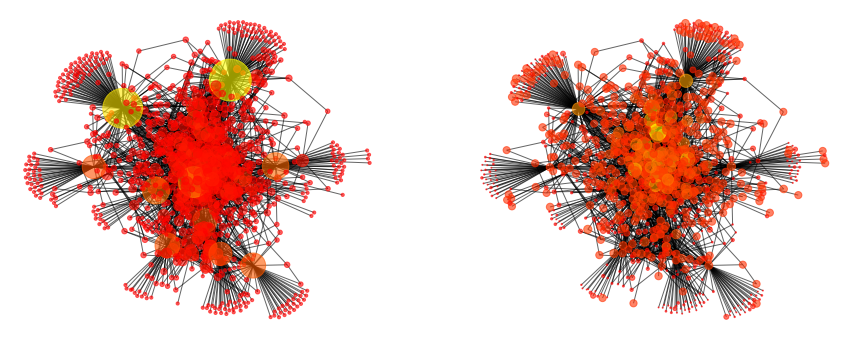

In [0]:
n = 21
step = 2
neis = n_step_subgraph(G,n,step)
print('Number of nodes: {}'.format(len(neis)))

figsize(15,6)
S = G.subgraph(neis)
pos = nx.spring_layout(S)
dc = list(dict(nx.degree_centrality(S)).values())
plt.subplot(1,2,1)
nx.draw(S,alpha = .6,node_color = dc,cmap = plt.get_cmap('autumn'),node_size = 10*np.array(list(dict(S.degree()).values())),pos =pos)

plt.subplot(1,2,2)
deg_lookup = {n:d for n,d in dict(nx.degree(G)).items() if n in neis}
s_deg = [deg_lookup[n] for n in S.nodes()]
nx.draw(S,alpha = .6,node_color = s_deg,cmap = plt.get_cmap('autumn'),node_size =  np.array(s_deg),pos = pos)
plt.show()

- There are a lot of star graph structures in the graph, with some complex intermedicate nodes inter-connected.
- Important nodes in a subgraph may not important in the whole graph, the interconnectted nodes can also be star centers, which is not shown in limited steps.
- Starts connected with other starts - by less important or very import nodes.

### 6. What do we want to know?    
**1. Artist recommendations**         
**2. Community finding**   
**3. Spread of information**        

### 7. Recommend friends

- Calculate similarity
- Select top nodes to recommend
- Exclude known positive
- Recommend

In [0]:
def recommend(G, to_rec = 0, n_th_closest = 0, searching = 100):
    # Takes a lot of memory if convert to ndarray or calculate pairwise distances
    A = nx.adj_matrix(G)

    # similarity calculations
    sim_dic = {}
    for n in range(1,searching + 1):
        if n!= to_rec:
            sim = 1 - spt.cosine(A[to_rec,:].toarray(),A[n,:].toarray())
            sim_dic[n] = sim

    # calculatee ranking scores and make recommendation
    ranking = sorted(sim_dic,key = lambda x: sim_dic.get(x),reverse = True)
    top_neighbors = np.nonzero(A[ranking[n_th_closest],:])[1]
    know_positive = np.nonzero(A[to_rec,:])[1]
    recommendations = set(top_neighbors).difference(set(know_positive))

    message = '''
        Recommend friends to {},
        From node: {}
        with label: {}
        exclude positive: {}
        Get recommendation: {}
    '''.format(to_rec,
               ranking[n_th_closest],
               top_neighbors,
               know_positive,
               recommendations)
    
    print(message)
    return recommendations

*您关注的XXX还关注了YYY*

In [0]:
recommend(G,4,0)


        Recommend friends to 4,
        From node: 99
        with label: [ 34  35  36  42  44 100 101 102 103 104 105 106 107 108]
        exclude positive: [    0    31    34    35    66    67    69    94    95   100   101   102
   103   106   108   113   114   115   116   123   124   125   129   130
   131   133   141   149   153   271   333   335   391   553  3121  4198
 12066 14545 22622 22623 22624 22625 22626 22627 22628 22629]
        Get recommendation: {36, 104, 105, 42, 107, 44}
    


{36, 42, 44, 104, 105, 107}

### Find Communities

In [0]:
def louvain(G,return_json = True):
    community = [comm for node, comm in best_partition(G).items()]
    if return_json:
        return json.dumps([{'node':int(i),'community':int(comm)} for i,comm in enumerate(community)],ensure_ascii = False)
    else:
        return community

In [0]:
def community_summary(community,top_n = 10):
    
    num_comms = np.unique(community).shape[0]
    size_comms = pd.DataFrame(Counter(community).most_common(),columns = ['CommunityID','CommunitySize'])

    print('Found {} Communities.\n'.format(num_comms))
    print('Top {} Communities overview.\n'.format(top_n))
    print(size_comms.head(top_n))

    return size_comms

Found 84 Communities.

Top 10 Communities overview.

   CommunityID  CommunitySize
0            2          16125
1           16          15628
2           10          13099
3           27           7710
4           26           6680
5            6           6585
6            0           5583
7            1           5170
8           29           4372
9           48           3685


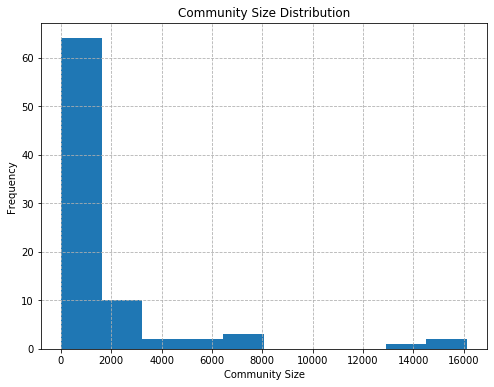

In [0]:
community = louvain(G,False)
size_comms = community_summary(community)

figsize(8,6)
plt.hist(size_comms.CommunitySize)
plt.grid(True,linestyle = '--')
plt.title("Community Size Distribution")
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.show()

There are some extremly large community, some medium sized and smaller ones.    
Let's look at the smaller ones first

In [0]:
pd.set_option('max_rows',100)
size_comms.head(100)

CommunityID  CommunitySize
0             2          16125
1            16          15628
2            10          13099
3            27           7710
4            26           6680
5             6           6585
6             0           5583
7             1           5170
8            29           4372
9            48           3685
10           12           2924
11           19           2790
12           21           2787
13           30           2539
14           17           2363
15           25           2271
16           11           2111
17           57           2005
18            7           1854
19           14           1642
20           24           1535
21           13           1533
22            9           1503
23           23           1417
24           20           1404
25           54           1286
26            3           1224
27           76           1221
28           22           1187
29           46           1153
30            5           1144
31           35           1136
32           61           1106
33            4           1094
34           28           1066
35           31           1027
36           45           1012
37           36           1004
38           63           1004
39           64           1002
40           68            963
41           56            916
42           47            910
43           39            896
44           44            840
45           58            836
46           37            767
47           15            711
48           49            701
49           75            691
50            8            687
51           32            682
52           43            666
53           73            663
54           40            658
55           51            644
56           53            640
57           18            618
58           71            617
59           50            574
60           38            560
61           70            537
62           55            528
63           69            524
64           67            512
65           59            510
66           34            509
67           65            505
68           78            501
69           60            491
70           33            483
71           42            483
72           74            404
73           62            371
74           72            354
75           41            328
76           66            281
77           52            232
78           82             51
79           79             47
80           77             10
81           81             10
82           80              9
83           83              7

In [0]:
def draw_community(G, community, comm_id = 82, size_multiplier = 20):
    comm_array = np.array(community)
    comm_nodes = np.array(G.nodes())[comm_array == comm_id]
    S = G.subgraph(comm_nodes)
    pos = nx.spring_layout(S)
    deg_lookup = {n:d for n,d in dict(nx.degree(G)).items() if n in S.nodes()}
    s_deg = [deg_lookup[n] for n in S.nodes()]
    figsize(8,6)
    nx.draw(S,alpha = .6,node_color = s_deg,cmap = plt.get_cmap('autumn'),node_size = size_multiplier*np.array(s_deg),pos = pos)

def draw_three_communities(G,community, comm_ids = [82,79, 83],size_multiplier = 20):
    figsize(24,8)
    for i,comm_id in enumerate(comm_ids):
        plt.subplot(1,3,i+1)
        draw_community(G,community,comm_id,size_multiplier = size_multiplier)
    plt.show()


### Community of Different sizes

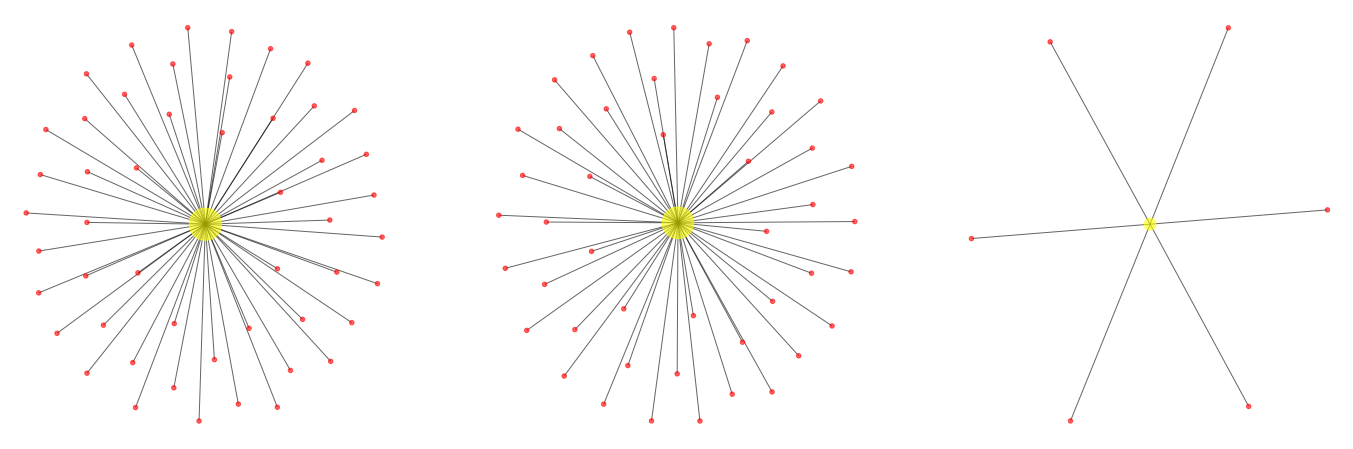

In [0]:
draw_three_communities(G,community, comm_ids = [82,79, 83])

**Very small communities are simple star graphs with most important node in the center**

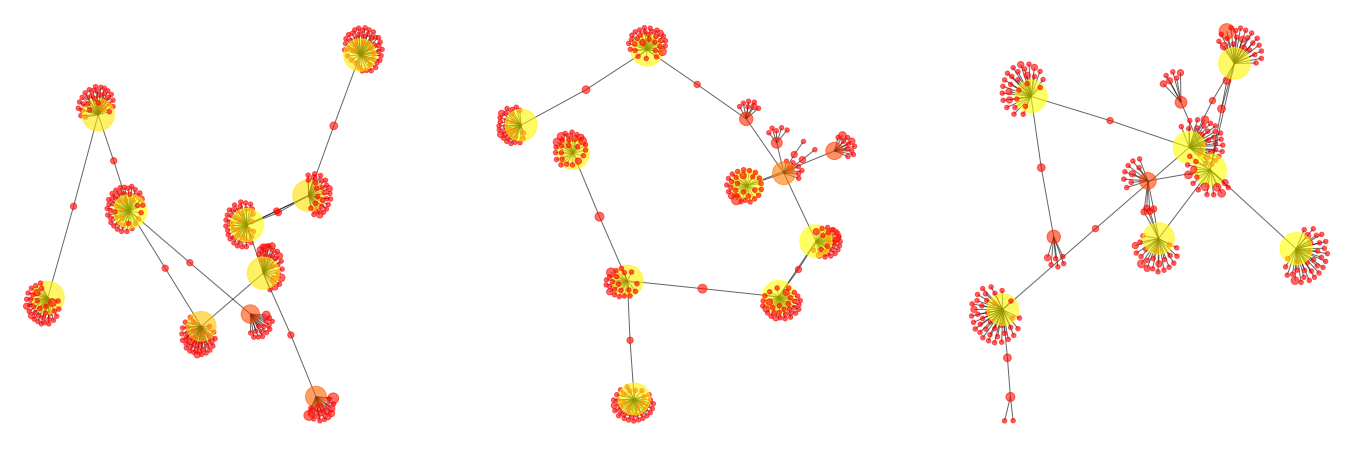

In [0]:
draw_three_communities(G,community, comm_ids = [41, 66, 52])

**Medium sized communities are sparse connected start graphs, most important nodes are also star centers**

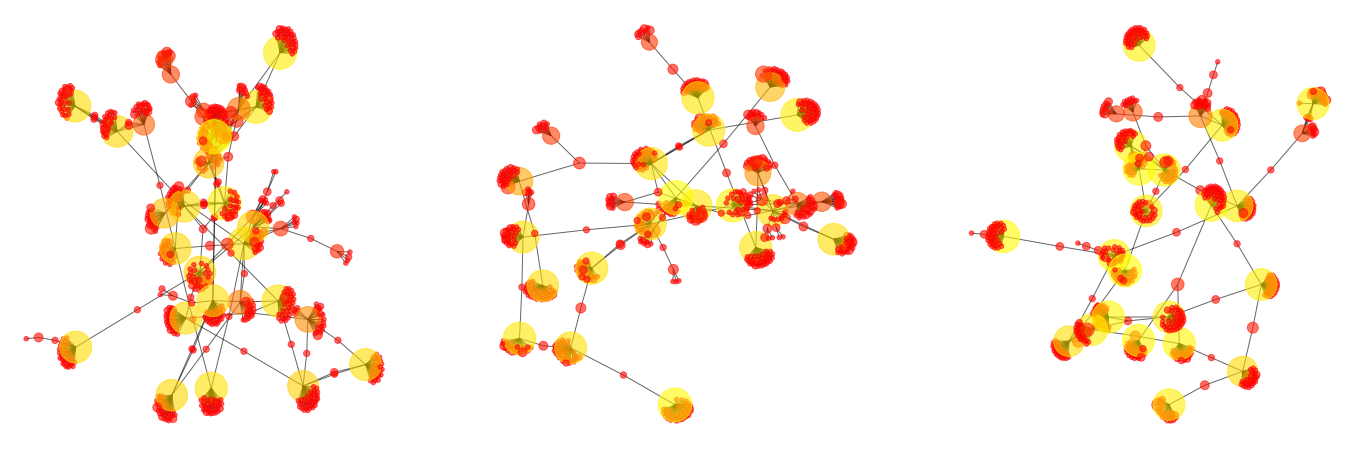

In [0]:
draw_three_communities(G,community, comm_ids = [15, 49, 75])

**Larger communities are bigger connected star graphs**

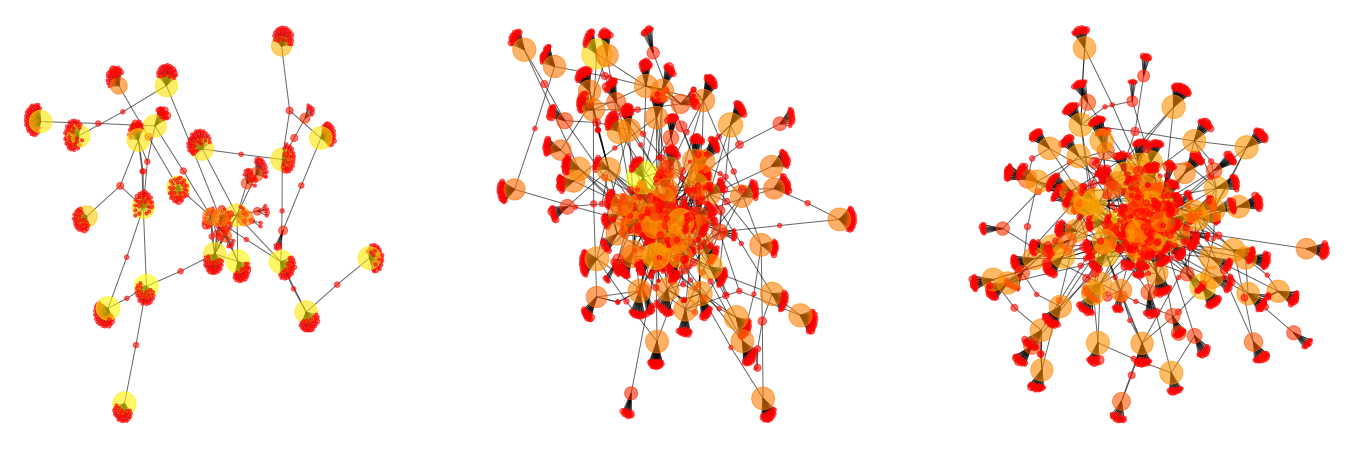

In [0]:
draw_three_communities(G,community, comm_ids = [37, 57, 11],size_multiplier=10)

**That is why the graph is slightly disassortative(-0.18)**

### Are there famous artists having many famous artist friends? - Page rank trial

In [0]:
pr_scores = nx.pagerank(G)
pr_sorted_nodes = sorted(pr_scores,key = lambda x: pr_scores.get(x),reverse = True)

Number of nodes: 288
Number of nodes: 279
Number of nodes: 260
Number of nodes: 266
Number of nodes: 247
Number of nodes: 249


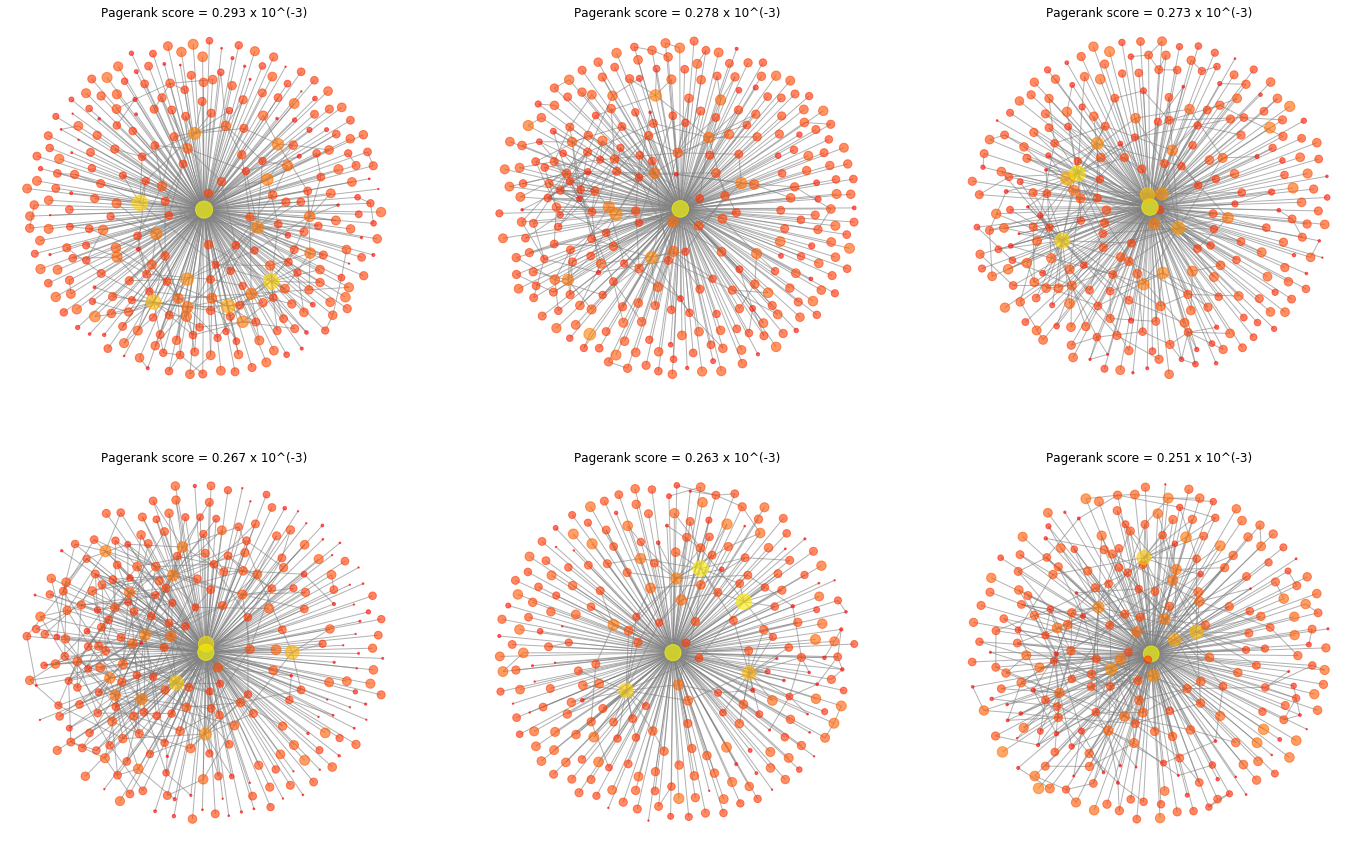

In [0]:
figsize(24,15)
for i in range(6):
    n = pr_sorted_nodes[i]
    step = 1
    neis = n_step_subgraph(G,n,step)
    print('Number of nodes: {}'.format(len(neis)))

    S = G.subgraph(neis)
    pos = nx.spring_layout(S)

    plt.subplot(2,3,i+1)
    # deg_lookup = {n:d for n,d in dict(nx.degree(G)).items() if n in neis}
    deg_lookup = {n:d for n,d in pr_scores.items() if n in neis}
    s_deg = [deg_lookup[n] for n in S.nodes()]
    nx.draw(S,alpha = .6,node_color = s_deg,cmap = plt.get_cmap('autumn'),node_size =  1000000*np.array(s_deg),pos = pos,edge_color='gray')
    plt.title('Pagerank score = {} x 10^(-3)'.format(round(1000*pr_scores.get(n,-100),3)))
plt.show()

*These are actually high degree nodes*

### Clique Finding

In [0]:
def find_n_summary_clique(G,plot = False):

    clique_size_dict = {}
    cliques_dictt = {}
    clique_sizes = []
    for ind,cli in enumerate(nx.find_cliques(G)):
        cliques_dict[ind] = cli
        clique_size_dict[ind] = len(cli)
        clique_sizes.append(len(cli))     
    if plot:
        figsize(8,6)
        plt.hist(clique_sizes,bins = 10,log = True,alpha = 0.9)
        plt.grid(True,linestyle = '--')
        plt.title("Clique size distribution")
        plt.show()   

    return {
        'clique_size_dict':clique_size_dict,
        'cliques_dict':cliques_dict
    }

In [0]:
def draw_clique_with_neis(G, clique_stats,clique_range = [4,5,6,7,8,9,10]):

    clique_size_dict = clique_stats.get('clique_size_dict')
    cliques_dictt = clique_stats.get('cliques_dict')


    # extract candidate cliques
    k_cliques = [k for k,v in clique_size_dict.items() if v in clique_range]

    for it in range(100):
        # random choizen 1 clique
        cli = np.random.choice(k_cliques)

        # retrieve the nodes and make subgraph
        cli_init = cliques_dict[cli]

        neighbors = []
        for n in cli_init:
            neighbors += list(G.neighbors(n))

        ns =  list(set(neighbors + cli_init))

        if len(ns)< 1000:


            S = G.subgraph(ns)

            cli_edges = [(u,v) for u,v in S.edges() if u in cli_init and v in cli_init]

            # calculate degree
            deg_lookup = {n:d for n,d in dict(nx.degree(G)).items() if n in ns}
            s_deg = [deg_lookup[n] for n in S.nodes()]
            init_deg = [deg_lookup[n] for n in cli_init]

            colors = [1 if n in cli_init else 2 for n in S.nodes() ]

            #make a drawing
            pos = nx.spring_layout(S)
            nx.draw(S,alpha = .4,node_color = colors,cmap = plt.get_cmap('Set2'),node_size =  10*np.array(s_deg),pos = pos,width = .2)
            # nx.draw(S,alpha = .6,node_color = colors,cmap = plt.get_cmap('Set2'),pos = pos,width = .2)
            nx.draw_networkx_edges(G,pos = pos,edgelist = cli_edges,edge_color='red',width = 2)
            nx.draw_networkx_nodes(G,pos,cli_init,10*np.array(init_deg))

            break

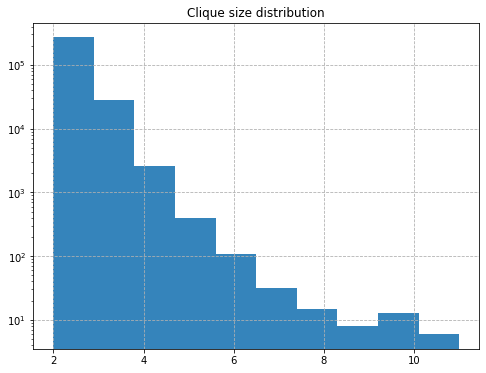

In [0]:
clique_stats = find_n_summary_clique(G,True)

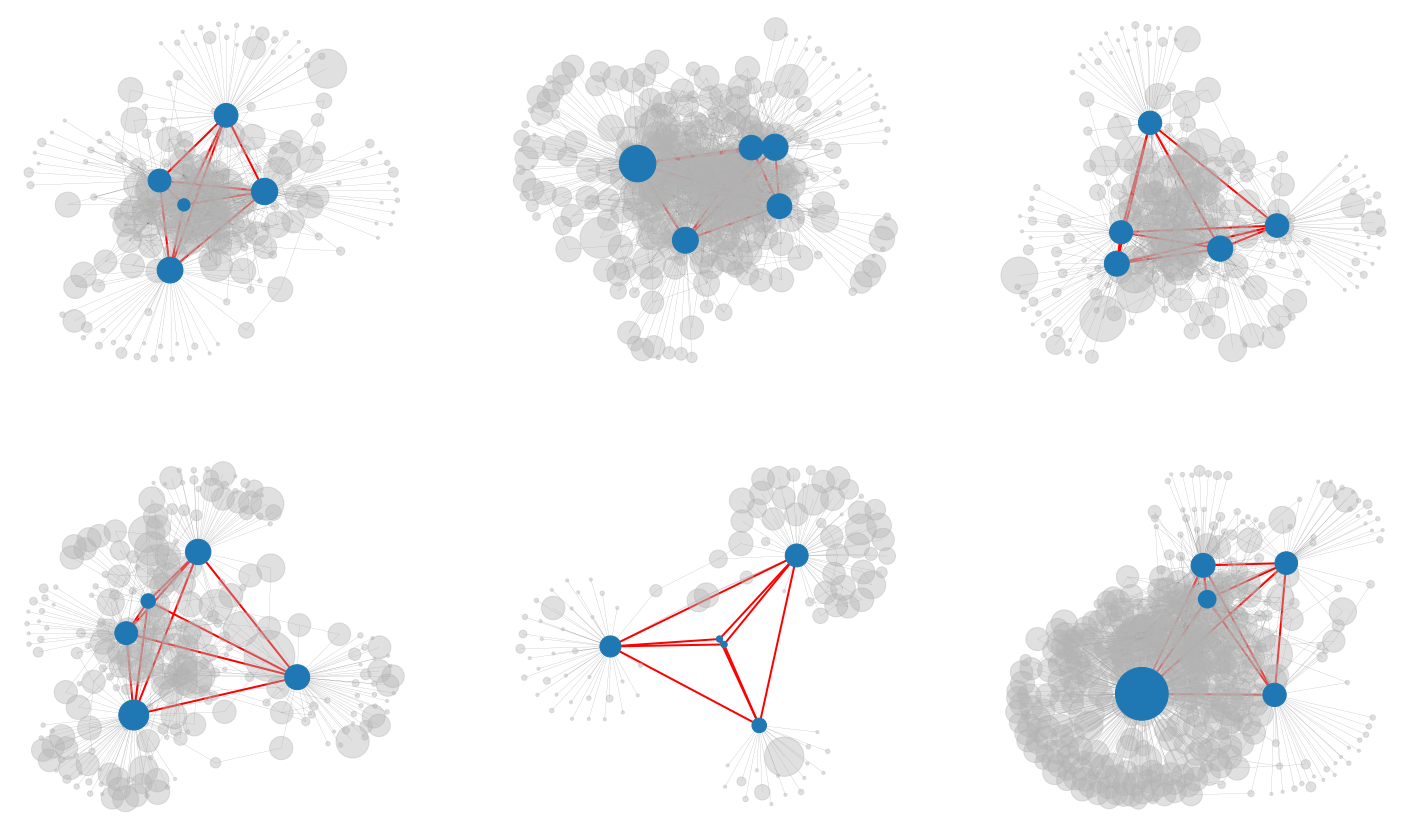

In [0]:
figsize(25,15)
for i in range(6):
    plt.subplot(2,3,i+1)
    draw_clique_with_neis(G,clique_stats,[5,6,7,8,9,10])
plt.show()

**Mid-sized nodes are more likely to form a clique**     
**Cycles are not meaningful in this problem**      

### Spread of information
*Seed one / many nodes & start spreading*

*Let's simulate a random walk (Independent Cascade)*

In [0]:
def douban_infection(G,start_node = 1, p_inf = 0.15, levels = 3):
    # Using adjacency matrix
    A = nx.adj_matrix(G)

    # keep record of infected nodes in each level of infection
    all_infected = [[start_node]]
    for lvl in range(levels):

        cur_level = []
        # this level infected starts from the last infected person
        for start_node in all_infected[-1]:

            # they just infect their neighbors
            neighbors = np.nonzero(A[start_node-1,:].toarray()[0])[0] + 1

            # and the neighbors not been infected
            neighbors = np.array(list({node for node in neighbors}.difference(set(n for lvl in all_infected for n in lvl))))

            # there is a probability of infection
            if len(neighbors) > 0:
                infected_nodes = neighbors[np.random.random(size = neighbors.shape[0]) < p_inf]
                cur_level += infected_nodes.tolist()
            else:
                pass
        # if not infected any one, stop!
        if len(cur_level) ==0: 
            print('Infection stop at {}st wave.'.format(lvl))
            break
        # append infected node at current level
        all_infected.append(cur_level)

    if lvl == levels:
        print('Infection propagates')
    return all_infected,lvl


flatten = lambda x:{n for lvl in x for n in lvl}

In [0]:
num_infect_history = []
waves = []

for _ in range(100):
    all_infected,lvl = douban_infection(G,1,.05,100)
    deg = G.degree(1)
    num_infections = len(flatten(all_infected))
    num_infect_history.append(num_infections)
    waves.append(lvl)

    print('Total infections: {}.'.format(num_infections))
    print("Node degree: {}.".format(deg))
    # S = G.subgraph(flatten(all_infected))
    # figsize(8,6)
    # nx.draw(S,alpha = 0.6)

Infection stop at 27st wave.
Total infections: 8987.
Node degree: 59.
Infection stop at 2st wave.
Total infections: 8.
Node degree: 59.
Infection stop at 24st wave.
Total infections: 9029.
Node degree: 59.
Infection stop at 0st wave.
Total infections: 1.
Node degree: 59.
Infection stop at 27st wave.
Total infections: 9056.
Node degree: 59.
Infection stop at 3st wave.
Total infections: 9.
Node degree: 59.
Infection stop at 24st wave.
Total infections: 8678.
Node degree: 59.
Infection stop at 21st wave.
Total infections: 9000.
Node degree: 59.
Infection stop at 2st wave.
Total infections: 7.
Node degree: 59.
Infection stop at 20st wave.
Total infections: 8743.
Node degree: 59.
Infection stop at 2st wave.
Total infections: 5.
Node degree: 59.
Infection stop at 20st wave.
Total infections: 8960.
Node degree: 59.
Infection stop at 6st wave.
Total infections: 17.
Node degree: 59.
Infection stop at 24st wave.
Total infections: 8706.
Node degree: 59.
Infection stop at 1st wave.
Total infection

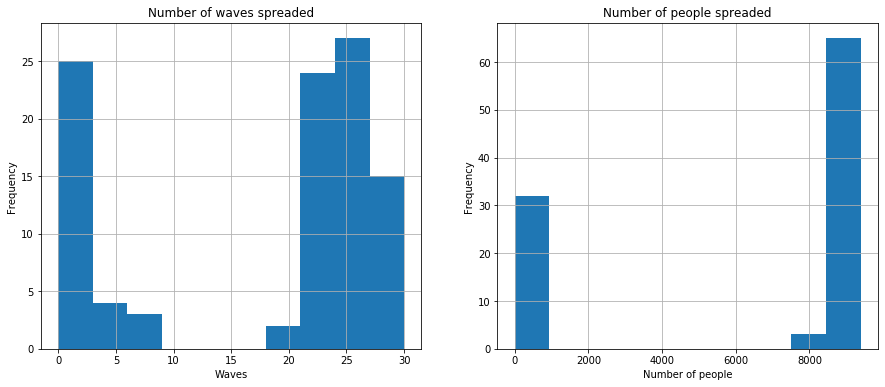

In [0]:
figsize(15,6)
plt.subplot(1,2,1)
plt.hist(waves)
plt.grid(True)
plt.title("Number of waves spreaded")
plt.xlabel("Waves")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(num_infect_history)
plt.grid(True)
plt.title("Number of people spreaded")
plt.xlabel("Number of people")
plt.ylabel("Frequency")
plt.show()

- 一个豆瓣的用户，有59个艺术家好友，需要推广一篇文章，豆瓣用户转发此文章的概率为5%。    
- 这篇文章可能在 0-10 波停止传播，也可能在20-30波停止传播。      
- 最终影响的用户可能在几十人左右，也可能在8000人附近。       
结论：网络推广初期很重要，初期做好了，就能扩散 


*Run more simulations starting from nodes with different node degrees*

# At least, we have a better understanding of the graph structure.

*TO BE CONTINUED*